# Linking drugbank targets to reactome reactions and pathways
- Samir Akre 03/25/2020


The goal of this notebook is to take parsed drugbank data listing drugs and the molecules they interact with and link the drugs to pathways they influence.

In [1]:
import neo4j_functions.driver as neo4j_driver
import pandas as pd
import importlib

## Importing drugbank target and entity list

In [2]:
# Taken from output of /Database/Drugs/CVD_UserCase_Drugbank_SamirAkre.ipynb
# In the AWS instance
drug_targets = pd.read_csv('lib/beta_blocker_drugbank_usercase.csv')

drug_targets.describe()

,drug_name,action,entity_name,entity_type,bioentity_id,drugbank_id,uniprot_id
count,49,49,49,49,49,49,49
unique,3,6,36,4,36,3,36
top,Carvedilol,substrate,Cytochrome P450 2D6,target,BE0002363,DB01136,P08183
freq,27,16,3,24,3,27,3


In [3]:
# Preview drug target file
drug_targets.head()

,drug_name,action,entity_name,entity_type,bioentity_id,drugbank_id,uniprot_id
0,Metoprolol,antagonist,Beta-1 adrenergic receptor,target,BE0000172,DB00264,P08588
1,Metoprolol,antagonist,Beta-2 adrenergic receptor,target,BE0000694,DB00264,P07550
2,Metoprolol,inhibitor,Solute carrier family 22 member 2,transporter,BE0003647,DB00264,O15244
3,Metoprolol,substrate,Multidrug resistance protein 1,transporter,BE0001032,DB00264,P08183
4,Metoprolol,inhibitor,Cytochrome P450 2D6,enzyme,BE0002363,DB00264,P10635


## Link drug targets to reactions and pathways via uniprotKB ids

2 queries ran per entity to find different paths to a reaction and subsequently a pathway

In [4]:
from tqdm.notebook import tqdm
importlib.reload(neo4j_driver)
driver = neo4j_driver.driver(uri = "bolt://localhost:7687", user = "neo4j", password = "Akre1234")

results = []
for identifier in tqdm(drug_targets.uniprot_id.unique()):
    query_1 = (
        """
        MATCH (n {databaseName: 'UniProt', identifier: '%s'})-[:referenceEntity]-()-[:hasComponent]-(:PhysicalEntity)-[:input|:output]-(r:Reaction)-[:hasEvent]-(p:Pathway)
        RETURN DISTINCT n.identifier, r.displayName, p.displayName
        """ % (identifier)
    )
    query_2 = (
        """
        MATCH (n {databaseName: 'UniProt', identifier: '%s'})-[:referenceEntity]-()-[:hasMember|:hasComponent]-(:PhysicalEntity)-[:physicalEntity]-(:CatalystActivity)-[]-(r:Reaction)-[]-(p:Pathway)
        RETURN DISTINCT n.identifier, r.displayName, p.displayName
        """ % (identifier)
    )
    for query in [query_1, query_2]:
        query_res = driver.run_query(query)
        result = driver.results_to_df(query_res, ['uniprot_id', 'reaction', 'pathway'])
        results.append(result)

In [5]:
pathways_df = pd.concat(results)
pathways_df.drop_duplicates().describe()

,uniprot_id,reaction,pathway
count,84,84,84
unique,24,61,35
top,P05177,CYPs hydroxylate DHA to 14(R)-HDHA,Synthesis of (16-20)-hydroxyeicosatetraenoic a...
freq,9,5,8


In [6]:
# Link found pathways to drug-entity list
target_pathways = drug_targets.merge(
    pathways_df.drop_duplicates(),
)
target_pathways.describe()

,drug_name,action,entity_name,entity_type,bioentity_id,drugbank_id,uniprot_id,reaction,pathway
count,135,135,135,135,135,135,135,135,135
unique,3,5,24,3,24,3,24,61,35
top,Carvedilol,substrate,Beta-2 adrenergic receptor,enzyme,BE0002433,DB01136,P07550,CYPs hydroxylate DHA to 14(R)-HDHA,Synthesis of (16-20)-hydroxyeicosatetraenoic a...
freq,64,67,18,85,18,64,18,9,15


### Plot Reactions and Pathways Per drug

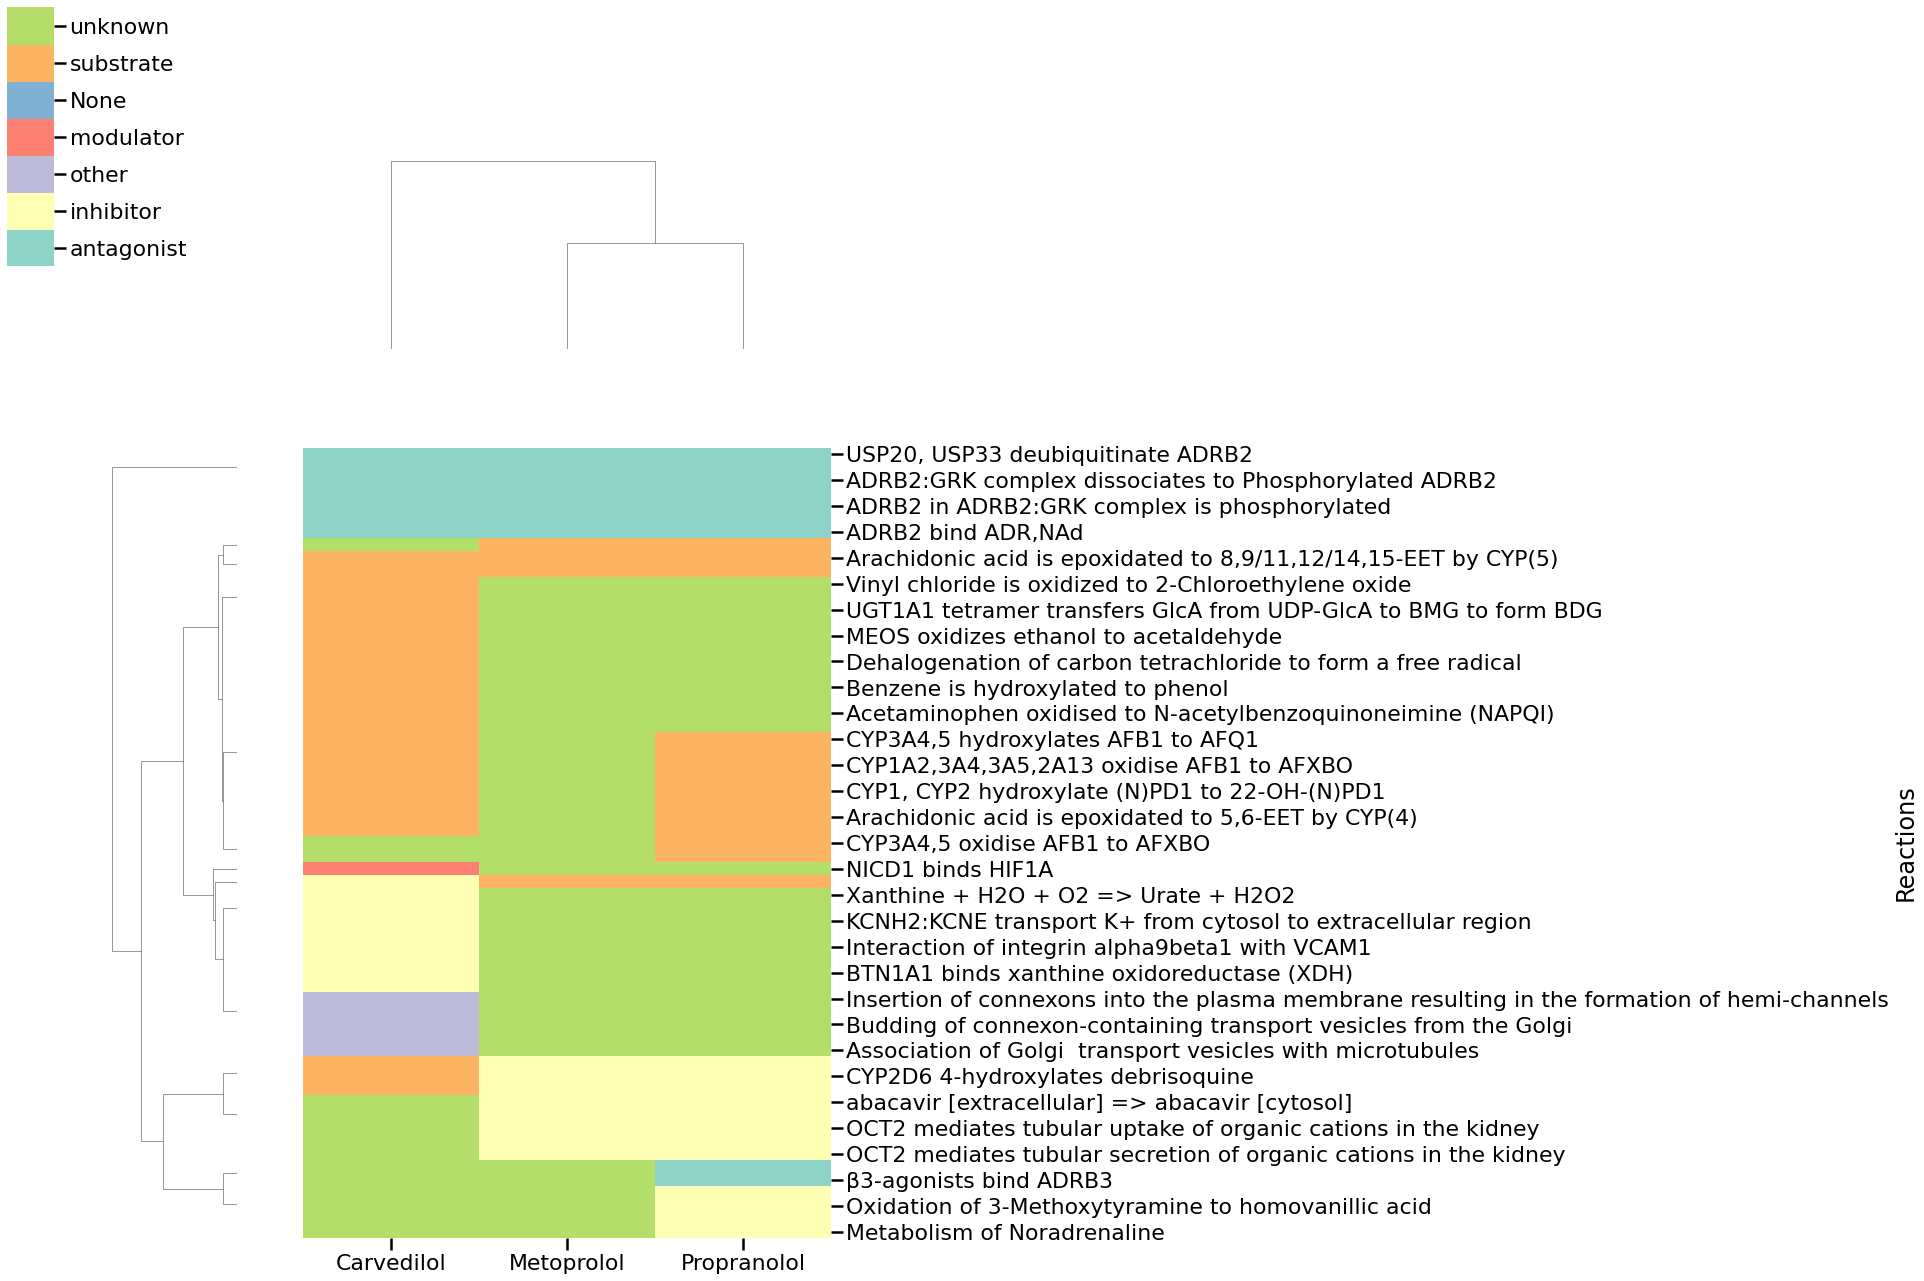

In [9]:
import seaborn as sns
sns.set_context('poster')
value_to_int = {j:i for i,j in enumerate(target_pathways.action.unique())} # like you did

df = target_pathways.pivot_table(
    columns='drug_name',
    index='reaction',
    values='action',
    fill_value='unknown',
    aggfunc='first'
)
value_to_int = {
    'antagonist': 0, 
    'inhibitor': 1, 
    'other': 2, 
    'modulator': 3,
    'None': 4,
    'substrate': 5,
    'unknown': 6
}
n = len(value_to_int)
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Set3", n) 
clust = sns.clustermap(df.replace(value_to_int), cmap=cmap, figsize=(13,20)) 
ax = clust.ax_heatmap
ax.set_xlabel('')
ax.set_ylabel('Reactions')
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))   

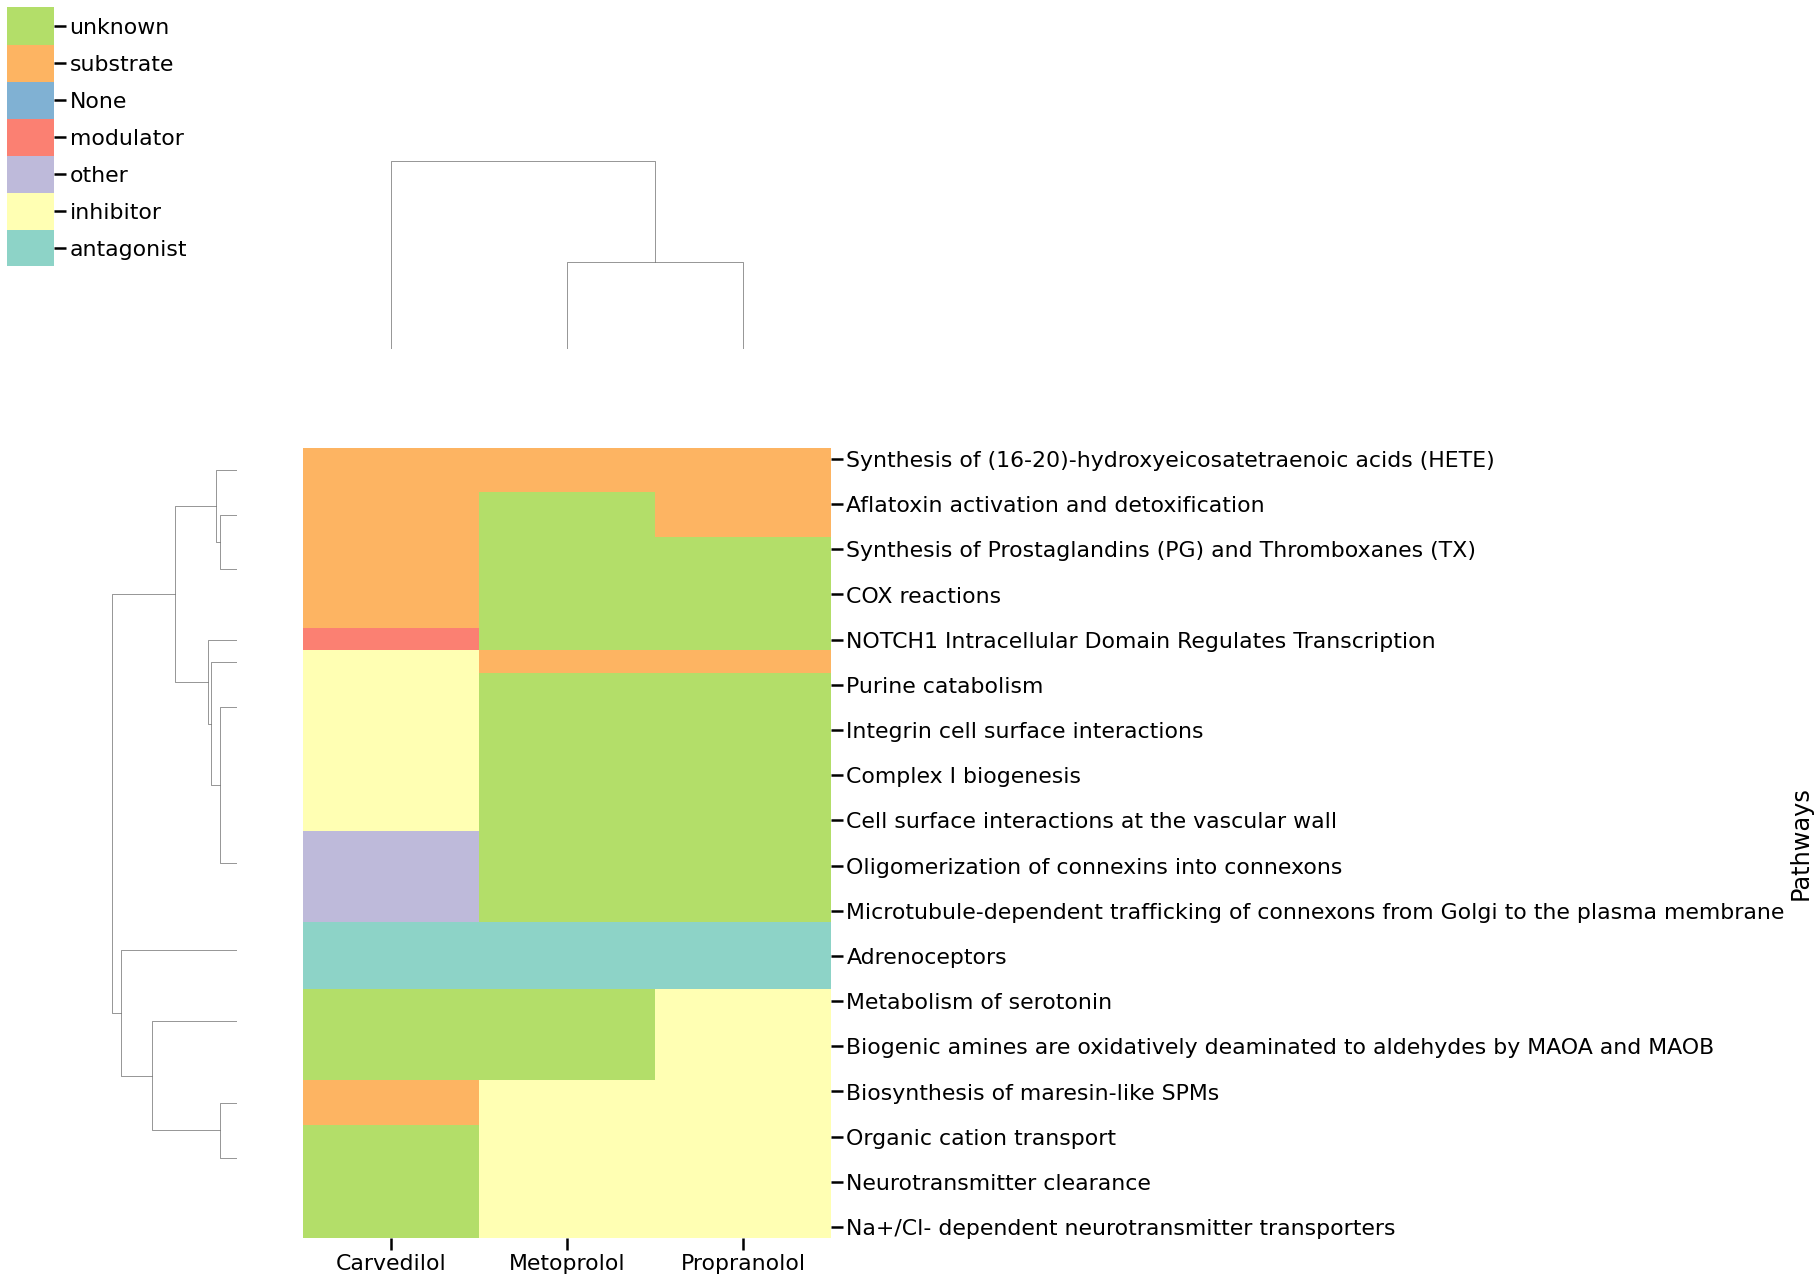

In [10]:

import seaborn as sns
sns.set_context('poster')
value_to_int = {j:i for i,j in enumerate(target_pathways.action.unique())} # like you did

df = target_pathways.pivot_table(
    columns='drug_name',
    index='pathway',
    values='action',
    fill_value='unknown',
    aggfunc='first'
)
value_to_int = {
    'antagonist': 0, 
    'inhibitor': 1, 
    'other': 2, 
    'modulator': 3,
    'None': 4,
    'substrate': 5,
    'unknown': 6
}
n = len(value_to_int)
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Set3", n) 
clust = sns.clustermap(df.replace(value_to_int), cmap=cmap, figsize=(13,20)) 
ax = clust.ax_heatmap
ax.set_xlabel('')
ax.set_ylabel('Pathways')
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))   